In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

In [2]:
df = pd.read_excel('limas.xlsx')
df = df.set_index("Datetime")
pd.to_datetime(df.index)

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01',
               '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
      

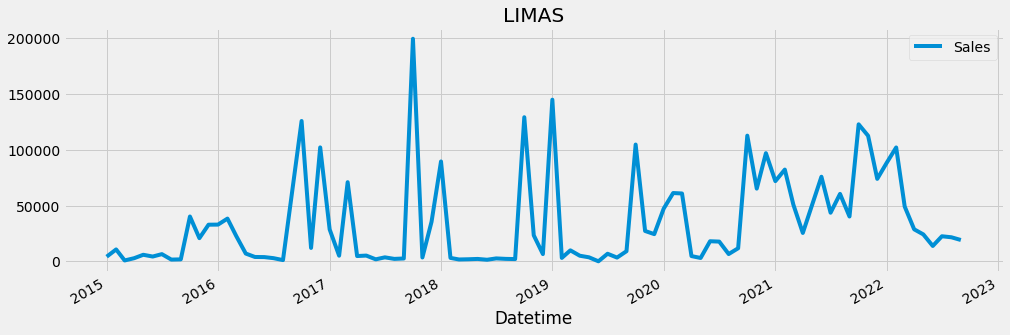

In [3]:
df.plot(style="-", figsize=(15,5), color=color_pal[0], title="LIMAS")
plt.show()

#### Test / Train Split

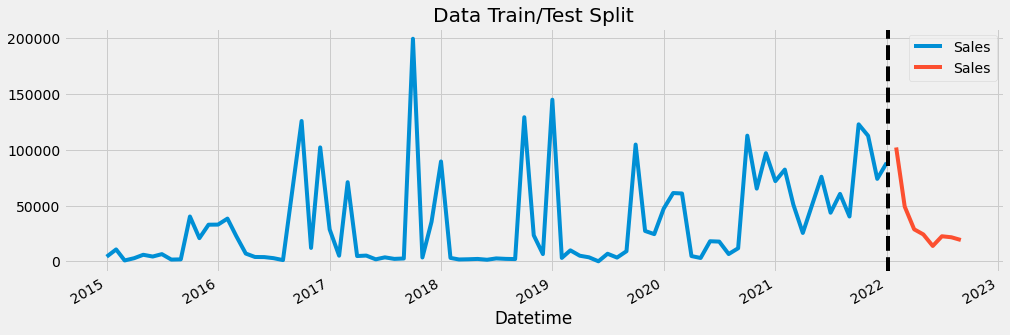

In [4]:
train = df.loc[df.index < "01-05-2022"]
test = df.loc[df.index >= "01-05-2022"]

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label="Train Set", title="Data Train/Test Split")
test.plot(ax=ax, label="Test Set")
ax.axvline("01-05-2022", color="black", ls="--")
plt.show()

<AxesSubplot:xlabel='Datetime'>

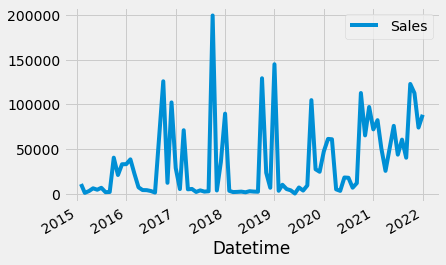

In [5]:
df.loc[(df.index > "01-01-2015") & (df.index < "01-08-2022")].plot()

#### Feature Creation

In [6]:
def create_features(df):
    #create time series fatures based on time series index
    df= df.copy()
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["quarter"] = df.index.quarter
    return df

df = create_features(df)

Visualización de las Features

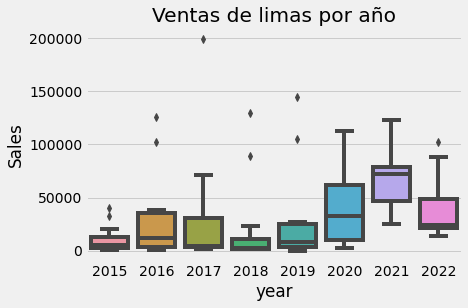

In [7]:
fig, ax = plt.subplots()
sns.boxplot(data=df, x="year", y="Sales")
ax.set_title("Ventas de limas por año")
plt.show()

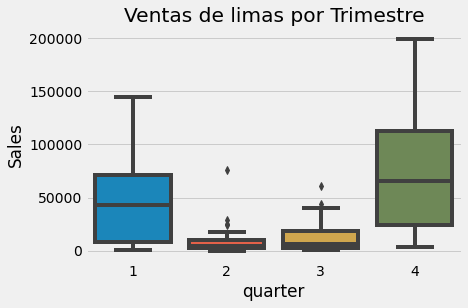

In [8]:
fig, ax = plt.subplots()
sns.boxplot(data=df, x="quarter", y="Sales")
ax.set_title("Ventas de limas por Trimestre")
plt.show()

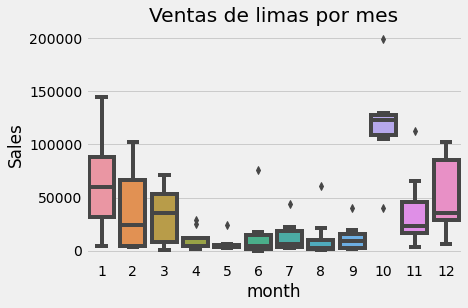

In [9]:
fig, ax = plt.subplots()
sns.boxplot(data=df, x="month", y="Sales")
ax.set_title("Ventas de limas por mes")
plt.show()

#### Crear el modelo

In [10]:
train = create_features(train)
test = create_features(test)

In [11]:
df.columns

Index(['Sales', 'month', 'year', 'quarter'], dtype='object')

In [12]:
FEATURES = ["month", "year", "quarter"]
TARGET = "Sales"

In [13]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [14]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                      learning_rate=0.01)
reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:53924.93531	validation_1-rmse:44040.84983
[100]	validation_0-rmse:27331.33383	validation_1-rmse:25751.12587
[186]	validation_0-rmse:17318.39608	validation_1-rmse:25634.78781


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [15]:
fi = pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=["importance"])

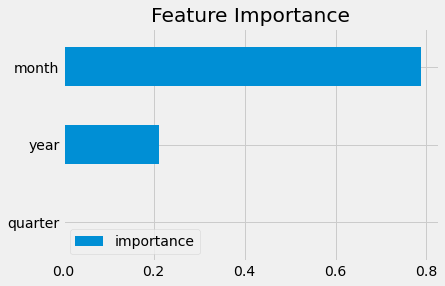

In [16]:
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")
plt.show()

#### Forecast en Test

In [17]:
test["prediction"] = reg.predict(X_test)

In [18]:
df = df.merge(test[["prediction"]], how="left", left_index=True, right_index=True)

In [19]:
df

,Sales,month,year,quarter,prediction
Datetime,,,,,
2015-01-01,4173,1,2015,1,NaN
2015-02-01,10667,2,2015,1,NaN
2015-03-01,797,3,2015,1,NaN
2015-04-01,2808,4,2015,2,NaN
2015-05-01,5886,5,2015,2,NaN
...,...,...,...,...,...
2022-05-01,24153,5,2022,2,37717.351562
2022-06-01,13789,6,2022,2,37717.351562
2022-07-01,22490,7,2022,3,37717.351562


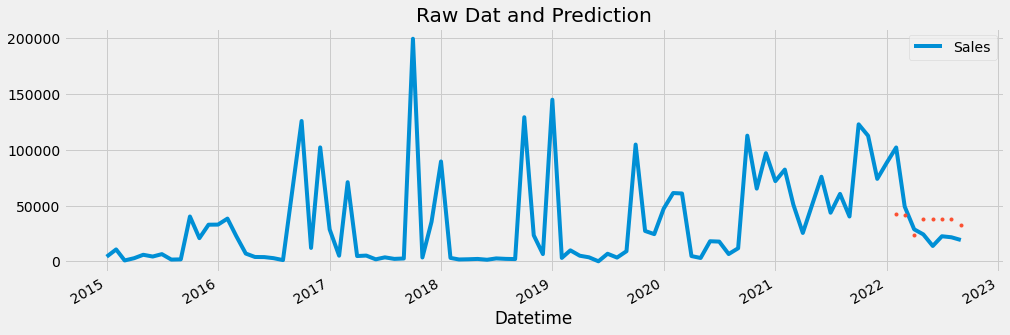

In [20]:
ax = df[["Sales"]].plot(figsize=(15, 5))
df["prediction"].plot(ax=ax, style=".")
ax.set_title("Raw Dat and Prediction")
plt.show()

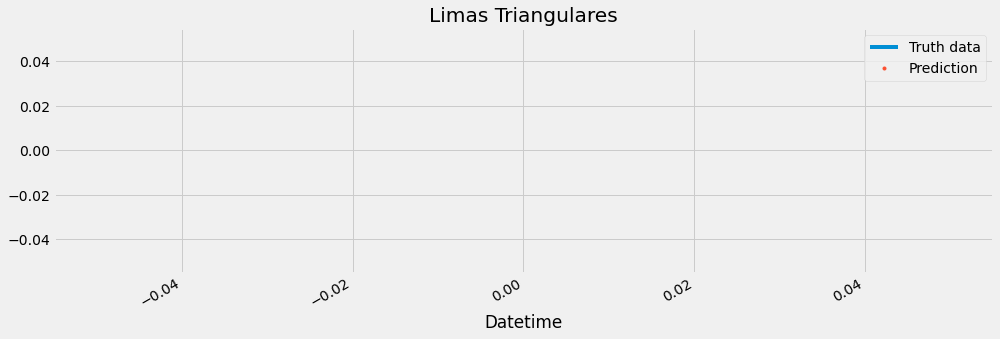

In [21]:
ax = df.loc[(df.index > "01-05-2022") & (df.index < "01-05-2022")]["Sales"] \
    .plot(figsize=(15, 5), title="Limas Triangulares")
df.loc[(df.index > "01-05-2022") & (df.index < "01-05-2022")]["prediction"] \
    .plot(style=".")
plt.legend(["Truth data", "Prediction"])
plt.show()

#### Calcular error

In [22]:
score = np.sqrt(mean_squared_error(test["Sales"], test["prediction"]))
print(f"RMSE Score on Test set: {score:0.2f}")

RMSE Score on Test set: 25043.35


In [23]:
test["error"] = np.abs(test[TARGET] - test["prediction"])

In [24]:
test["date"] = test.index.date

In [25]:
test.groupby(["date"])["error"].mean().sort_values(ascending=False).head(5)

date
2022-02-01    59284.187500
2022-06-01    23928.351562
2022-08-01    16136.351562
2022-07-01    15227.351562
2022-05-01    13564.351562
Name: error, dtype: float64

In [26]:
test.groupby(["date"])["error"].mean().sort_values(ascending=True).head(5)

date
2022-04-01     5254.960938
2022-03-01     7451.164062
2022-09-01    13068.806641
2022-05-01    13564.351562
2022-07-01    15227.351562
Name: error, dtype: float64